# MomentsLD Parameter Analysis: Best Fit vs Ground Truth

This notebook analyzes the MomentsLD optimization results from split migration experiments, comparing best fit parameters against ground truth values and visualizing parameter distributions across replicates. MomentsLD uses linkage disequilibrium (LD) statistics for demographic inference.

## Import Required Libraries

Import necessary libraries for data manipulation and visualization.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from pathlib import Path
import glob
from scipy import stats

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Set Up Data Paths

Define paths to the experiment directories containing simulations and MomentsLD results.

In [10]:
# Define base paths
base_path = Path('/home/akapoor/kernlab/Infer_Demography/experiments/split_migration')
simulations_path = base_path / 'simulations'
inferences_path = base_path / 'inferences'

print(f"Base path: {base_path}")
print(f"Simulations path: {simulations_path}")
print(f"Inferences path: {inferences_path}")

# Check if paths exist
print(f"\nPaths exist:")
print(f"Simulations: {simulations_path.exists()}")
print(f"Inferences: {inferences_path.exists()}")

# Check MomentsLD results structure
momentsld_dirs = list(inferences_path.glob('sim_*/MomentsLD'))
print(f"\nFound {len(momentsld_dirs)} MomentsLD result directories")
if momentsld_dirs:
    print(f"Example: {momentsld_dirs[0]}")
    # List files in first MomentsLD directory
    example_files = list(momentsld_dirs[0].glob('*'))
    print(f"Files in MomentsLD directory:")
    for f in example_files[:10]:  # Show first 10 files
        print(f"  {f.name}")

Base path: /home/akapoor/kernlab/Infer_Demography/experiments/split_migration
Simulations path: /home/akapoor/kernlab/Infer_Demography/experiments/split_migration/simulations
Inferences path: /home/akapoor/kernlab/Infer_Demography/experiments/split_migration/inferences

Paths exist:
Simulations: True
Inferences: True

Found 10 MomentsLD result directories
Example: /home/akapoor/kernlab/Infer_Demography/experiments/split_migration/inferences/sim_4/MomentsLD
Files in MomentsLD directory:
  empirical_vs_theoretical_comparison.pdf
  bootstrap_sets.pkl
  means.varcovs.pkl
  best_fit.pkl
  windows
  LD_stats


## Load Ground Truth Parameters

Load the true parameter values used for each simulation replicate.

In [11]:
def load_ground_truth_params(sim_dir):
    """Load ground truth parameters from a simulation directory."""
    sampled_params_file = sim_dir / 'sampled_params.pkl'
    if sampled_params_file.exists():
        with open(sampled_params_file, 'rb') as f:
            return pickle.load(f)
    return None

# Load ground truth parameters for all simulations
ground_truth_data = []
# Look for numbered directories (0, 1, 2, ...) not sim_* pattern
sim_dirs = sorted([d for d in simulations_path.iterdir() if d.is_dir() and d.name.isdigit()])

print(f"Loading ground truth parameters from {len(sim_dirs)} simulations...")

for sim_dir in sim_dirs:
    sim_id = int(sim_dir.name)  # Directory name is just the number
    params = load_ground_truth_params(sim_dir)
    
    if params is not None:
        params['sim_id'] = sim_id
        ground_truth_data.append(params)
        if sim_id == 0:  # Debug: show what's in the first simulation
            print(f"DEBUG: Simulation 0 ground truth parameters: {params}")

# Convert to DataFrame
gt_df = pd.DataFrame(ground_truth_data)
print(f"\nLoaded ground truth for {len(gt_df)} simulations")
if not gt_df.empty:
    print("\nGround truth parameter summary:")
    print(gt_df.describe())
else:
    print("ERROR: No ground truth data loaded!")

Loading ground truth parameters from 10 simulations...
DEBUG: Simulation 0 ground truth parameters: {'N0': 6509.395290119346, 'N1': 21819.56388792304, 'N2': 29145.584947278836, 'm12': 1.1373987979180036e-05, 'm21': 9.523689092386513e-05, 't_split': 12936.200198624776, 'sim_id': 0}

Loaded ground truth for 10 simulations

Ground truth parameter summary:
                 N0            N1            N2        m12        m21  \
count     10.000000     10.000000     10.000000  10.000000  10.000000   
mean   16636.158182  19423.240408  14224.856144   0.000043   0.000067   
std     8760.337366   8370.263479   8902.344842   0.000035   0.000026   
min     4779.527674   2138.486586   1623.150774   0.000001   0.000016   
25%     7887.271609  14985.130436   7454.828701   0.000006   0.000048   
50%    19670.898369  19472.287204  14968.081431   0.000052   0.000072   
75%    24343.992643  26639.531073  18549.607519   0.000066   0.000090   
max    25409.824103  29002.698283  29145.584947   0.000099   

## Load MomentsLD Best Fit Results

Load the best fit parameters from MomentsLD optimization for each simulation.

In [12]:
def load_momentsld_results(momentsld_dir):
    """Load MomentsLD best fit results from a MomentsLD directory."""
    best_fit_file = momentsld_dir / 'best_fit.pkl'
    if best_fit_file.exists():
        with open(best_fit_file, 'rb') as f:
            return pickle.load(f)
    return None

# Load MomentsLD results for all simulations
momentsld_data = []

print(f"Loading MomentsLD results from {len(momentsld_dirs)} directories...")

for momentsld_dir in sorted(momentsld_dirs):
    # Extract sim_id from path
    sim_id = int(momentsld_dir.parent.name.split('_')[1])
    results = load_momentsld_results(momentsld_dir)
    
    if results is not None:
        # Extract best fit parameters
        best_params = results.get('best_params', {})
        # Note: key is 'best_lls' not 'best_ll'
        best_ll = results.get('best_lls', np.nan)
        
        # Add simulation metadata
        result_entry = best_params.copy()
        result_entry['sim_id'] = sim_id
        result_entry['log_likelihood'] = best_ll
        
        momentsld_data.append(result_entry)

# Convert to DataFrame
momentsld_df = pd.DataFrame(momentsld_data)
print(f"\nLoaded MomentsLD results for {len(momentsld_df)} simulations")

if not momentsld_df.empty:
    print("\nMomentsLD parameter summary:")
    # Show numeric columns only
    numeric_cols = momentsld_df.select_dtypes(include=[np.number]).columns
    print(momentsld_df[numeric_cols].describe())
else:
    print("No MomentsLD results found!")

Loading MomentsLD results from 10 directories...

Loaded MomentsLD results for 10 simulations

MomentsLD parameter summary:
                 N0            N1            N2           m12           m21  \
count     10.000000     10.000000     10.000000  1.000000e+01  1.000000e+01   
mean   16665.633887  18536.582387  12470.793747  3.566361e-05  6.068861e-05   
std     9155.166930   8523.722787   7747.411938  3.472404e-05  3.351926e-05   
min     4676.333646   2235.818970   1674.077782  1.000000e-08  1.000000e-08   
25%     8076.632162  15007.776523   7426.435475  5.476975e-06  4.404832e-05   
50%    19526.563404  17579.282907  11144.334487  2.595674e-05  6.496000e-05   
75%    24475.387605  26405.352665  16858.671076  6.576107e-05  8.521234e-05   
max    27506.262649  28354.276993  26189.354836  8.773149e-05  1.000000e-04   

            t_split    sim_id  log_likelihood  
count     10.000000  10.00000       10.000000  
mean   10794.427075   4.50000   -58143.768886  
std     7158.610067 

## Merge Ground Truth and MomentsLD Results

Combine the ground truth and best fit parameters for comparison analysis.

In [13]:
# Merge ground truth and MomentsLD results
if not gt_df.empty and not momentsld_df.empty:
    # Merge on sim_id
    merged_df = pd.merge(gt_df, momentsld_df, on='sim_id', suffixes=('_true', '_momentsld'))
    
    print(f"Successfully merged data for {len(merged_df)} simulations")
    print(f"\nColumns in merged dataset:")
    for col in merged_df.columns:
        print(f"  {col}")
        
    # Display first few rows
    print(f"\nFirst 5 rows of merged data:")
    print(merged_df.head())
else:
    print("Cannot merge - missing ground truth or MomentsLD data")
    merged_df = pd.DataFrame()

Successfully merged data for 10 simulations

Columns in merged dataset:
  N0_true
  N1_true
  N2_true
  m12_true
  m21_true
  t_split_true
  sim_id
  N0_momentsld
  N1_momentsld
  N2_momentsld
  m12_momentsld
  m21_momentsld
  t_split_momentsld
  log_likelihood

First 5 rows of merged data:
        N0_true       N1_true       N2_true  m12_true  m21_true  t_split_true  \
0   6509.395290  21819.563888  29145.584947  0.000011  0.000095  12936.200199   
1  22367.050599  23660.176314   1623.150774  0.000074  0.000046   5426.346015   
2   8747.213749  27632.649326  10443.340378  0.000005  0.000069  19543.517996   
3   4779.527674  16700.734981  12627.281937  0.000066  0.000047   5992.494154   
4   7600.624229  17125.010521   6458.658142  0.000001  0.000076  14923.647552   

   sim_id  N0_momentsld  N1_momentsld  N2_momentsld  m12_momentsld  \
0       0   5247.393787  16947.139140  26189.354836       0.000006   
1       1  22065.667667  22567.780031   1674.077782       0.000063   
2       2  

## Parameter Comparison Analysis

Compare the inferred parameters with ground truth values.

In [14]:
if not merged_df.empty:
    # Define parameter pairs for comparison
    param_pairs = []
    
    # Find matching parameter names
    for col in merged_df.columns:
        if col.endswith('_true'):
            param_name = col.replace('_true', '')
            momentsld_col = param_name + '_momentsld'
            if momentsld_col in merged_df.columns:
                param_pairs.append((param_name, col, momentsld_col))
    
    print(f"Found {len(param_pairs)} parameter pairs for comparison:")
    for param_name, true_col, fit_col in param_pairs:
        print(f"  {param_name}: {true_col} vs {fit_col}")
    
    # Calculate relative errors
    comparison_data = []
    
    for param_name, true_col, fit_col in param_pairs:
        for idx, row in merged_df.iterrows():
            true_val = row[true_col]
            fit_val = row[fit_col]
            
            if pd.notna(true_val) and pd.notna(fit_val) and true_val != 0:
                rel_error = (fit_val - true_val) / true_val
                abs_rel_error = abs(rel_error)
                
                comparison_data.append({
                    'sim_id': row['sim_id'],
                    'parameter': param_name,
                    'true_value': true_val,
                    'fitted_value': fit_val,
                    'relative_error': rel_error,
                    'abs_relative_error': abs_rel_error,
                    'log_likelihood': row.get('log_likelihood', np.nan)
                })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(f"\nCreated comparison dataset with {len(comparison_df)} parameter comparisons")
    
    if not comparison_df.empty:
        print("\nRelative error summary by parameter:")
        error_summary = comparison_df.groupby('parameter')['relative_error'].agg([
            'count', 'mean', 'std', 'median', 
            lambda x: np.percentile(x, 25), 
            lambda x: np.percentile(x, 75)
        ]).round(4)
        error_summary.columns = ['count', 'mean', 'std', 'median', 'q25', 'q75']
        print(error_summary)
else:
    print("No data available for parameter comparison")
    comparison_df = pd.DataFrame()

Found 6 parameter pairs for comparison:
  N0: N0_true vs N0_momentsld
  N1: N1_true vs N1_momentsld
  N2: N2_true vs N2_momentsld
  m12: m12_true vs m12_momentsld
  m21: m21_true vs m21_momentsld
  t_split: t_split_true vs t_split_momentsld

Created comparison dataset with 60 parameter comparisons

Relative error summary by parameter:
           count    mean     std  median     q25     q75
parameter                                               
N0            10 -0.0136  0.0840 -0.0064 -0.0322  0.0208
N1            10 -0.0423  0.1271  0.0020 -0.0402  0.0422
N2            10 -0.0694  0.1827 -0.0347 -0.1081  0.0216
m12           10  0.0181  0.6116 -0.0427 -0.2179  0.1390
m21           10 -0.0484  0.3510  0.0584 -0.0778  0.1198
t_split       10  0.0938  0.2983  0.0082 -0.0587  0.1417


## Visualize Parameter Accuracy

Create plots to visualize how well MomentsLD recovers the true parameters.

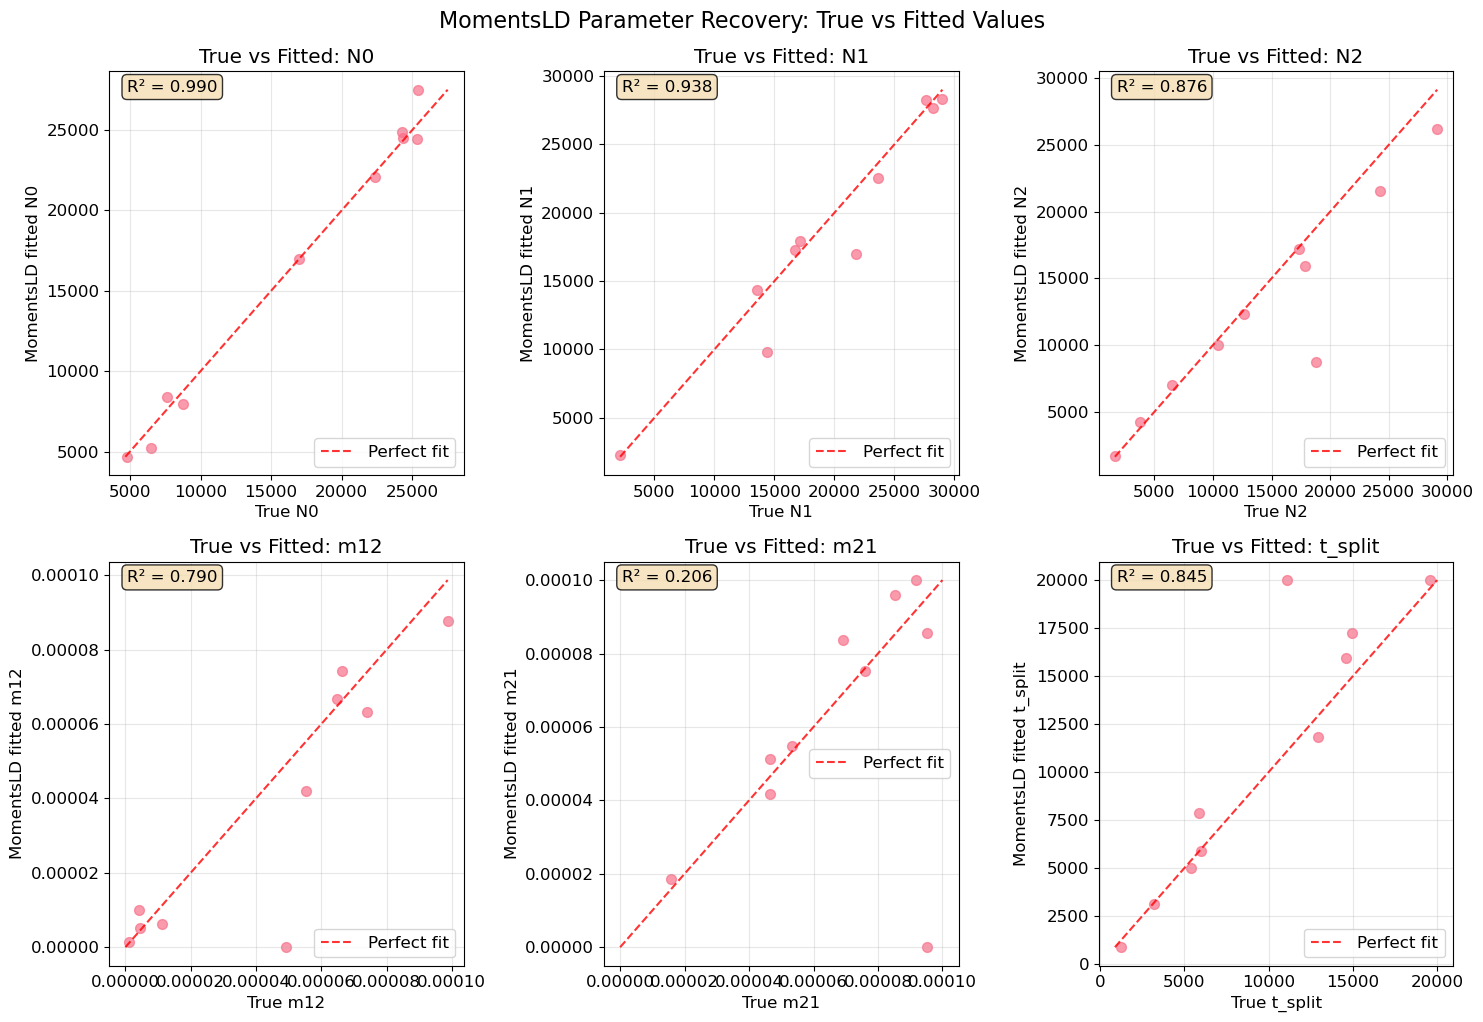

In [15]:
if not comparison_df.empty:
    # 1. True vs Fitted Values Scatter Plot
    unique_params = comparison_df['parameter'].unique()
    n_params = len(unique_params)
    
    fig, axes = plt.subplots(2, (n_params + 1) // 2, figsize=(15, 10))
    if n_params == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, param in enumerate(unique_params):
        if i >= len(axes):
            break
            
        param_data = comparison_df[comparison_df['parameter'] == param]
        
        ax = axes[i]
        ax.scatter(param_data['true_value'], param_data['fitted_value'], 
                  alpha=0.7, s=50)
        
        # Add perfect fit line
        min_val = min(param_data['true_value'].min(), param_data['fitted_value'].min())
        max_val = max(param_data['true_value'].max(), param_data['fitted_value'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect fit')
        
        ax.set_xlabel(f'True {param}')
        ax.set_ylabel(f'MomentsLD fitted {param}')
        ax.set_title(f'True vs Fitted: {param}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Calculate and display R²
        r_squared = stats.pearsonr(param_data['true_value'], param_data['fitted_value'])[0]**2
        ax.text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=ax.transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('MomentsLD Parameter Recovery: True vs Fitted Values', y=1.02, fontsize=16)
    plt.show()

else:
    print("No comparison data available for plotting")

In [ ]:
if not comparison_df.empty:
    # 2. Relative Error Distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot of relative errors by parameter
    ax1 = axes[0]
    comparison_df.boxplot(column='relative_error', by='parameter', ax=ax1)
    ax1.set_title('Relative Error Distribution by Parameter')
    ax1.set_xlabel('Parameter')
    ax1.set_ylabel('Relative Error')
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.8)
    ax1.grid(True, alpha=0.3)
    
    # Histogram of absolute relative errors
    ax2 = axes[1]
    ax2.hist(comparison_df['abs_relative_error'], bins=20, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Absolute Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Absolute Relative Errors')
    ax2.axvline(x=0.1, color='r', linestyle='--', alpha=0.8, label='10% error')
    ax2.axvline(x=0.2, color='orange', linestyle='--', alpha=0.8, label='20% error')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print accuracy statistics
    print("MomentsLD Parameter Accuracy Summary:")
    print(f"  Parameters within 10% error: {(comparison_df['abs_relative_error'] <= 0.1).mean()*100:.1f}%")
    print(f"  Parameters within 20% error: {(comparison_df['abs_relative_error'] <= 0.2).mean()*100:.1f}%")
    print(f"  Parameters within 50% error: {(comparison_df['abs_relative_error'] <= 0.5).mean()*100:.1f}%")

## Log-Likelihood Analysis

Analyze the log-likelihood values achieved by MomentsLD optimization.

In [ ]:
if not momentsld_df.empty and 'log_likelihood' in momentsld_df.columns:
    # Log-likelihood distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram of log-likelihoods
    ax1 = axes[0]
    valid_lls = momentsld_df['log_likelihood'].dropna()
    ax1.hist(valid_lls, bins=20, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Log-Likelihood')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of MomentsLD Log-Likelihoods')
    ax1.grid(True, alpha=0.3)
    
    # Add summary statistics
    ax1.axvline(x=valid_lls.mean(), color='r', linestyle='--', 
                label=f'Mean: {valid_lls.mean():.0f}')
    ax1.axvline(x=valid_lls.median(), color='orange', linestyle='--',
                label=f'Median: {valid_lls.median():.0f}')
    ax1.legend()
    
    # Log-likelihood vs simulation ID
    ax2 = axes[1]
    ax2.scatter(momentsld_df['sim_id'], momentsld_df['log_likelihood'], alpha=0.7)
    ax2.set_xlabel('Simulation ID')
    ax2.set_ylabel('Log-Likelihood')
    ax2.set_title('Log-Likelihood by Simulation')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Log-Likelihood Summary:")
    print(f"  Count: {valid_lls.count()}")
    print(f"  Mean: {valid_lls.mean():.2f}")
    print(f"  Std: {valid_lls.std():.2f}")
    print(f"  Min: {valid_lls.min():.2f}")
    print(f"  Max: {valid_lls.max():.2f}")

else:
    print("No log-likelihood data available")

## LD Statistics Analysis

Analyze the linkage disequilibrium statistics and empirical data quality.

In [ ]:
def load_ld_statistics(momentsld_dir):
    """Load LD statistics from MomentsLD directory."""
    means_varcovs_file = momentsld_dir / 'means.varcovs.pkl'
    if means_varcovs_file.exists():
        with open(means_varcovs_file, 'rb') as f:
            return pickle.load(f)
    return None

# Load LD statistics for analysis
ld_stats_data = []

print("Loading LD statistics from MomentsLD results...")

for momentsld_dir in sorted(momentsld_dirs[:5]):  # Analyze first 5 for speed
    sim_id = int(momentsld_dir.parent.name.split('_')[1])
    ld_stats = load_ld_statistics(momentsld_dir)
    
    if ld_stats is not None:
        # Extract basic statistics
        means = ld_stats.get('means', [])
        varcovs = ld_stats.get('varcovs', [])
        
        ld_stats_data.append({
            'sim_id': sim_id,
            'n_statistics': len(means) if means else 0,
            'mean_statistic_value': np.mean([np.mean(m) for m in means if len(m) > 0]),
            'total_variance': np.sum([np.sum(np.diag(vc)) for vc in varcovs if len(vc) > 0])
        })

if ld_stats_data:
    ld_stats_df = pd.DataFrame(ld_stats_data)
    print(f"\nLD Statistics Summary (n={len(ld_stats_df)} simulations):")
    print(ld_stats_df.describe())
    
    # Plot LD statistics overview
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1 = axes[0]
    ax1.bar(range(len(ld_stats_df)), ld_stats_df['n_statistics'])
    ax1.set_xlabel('Simulation')
    ax1.set_ylabel('Number of LD Statistics')
    ax1.set_title('Number of LD Statistics per Simulation')
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    ax2.scatter(ld_stats_df['mean_statistic_value'], ld_stats_df['total_variance'])
    ax2.set_xlabel('Mean LD Statistic Value')
    ax2.set_ylabel('Total Variance')
    ax2.set_title('LD Statistics: Mean vs Variance')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

else:
    print("No LD statistics data could be loaded")

## Comparison with Other Methods

If available, compare MomentsLD results with dadi and moments results.

In [ ]:
# Look for dadi and moments results for comparison
dadi_results_path = inferences_path / 'sim_0' / 'dadi'
moments_results_path = inferences_path / 'sim_0' / 'moments'

print("Checking for other inference method results...")
print(f"Dadi results exist: {dadi_results_path.exists() if dadi_results_path else False}")
print(f"Moments results exist: {moments_results_path.exists() if moments_results_path else False}")

# If other methods exist, load and compare
def load_method_results(method_path, method_name):
    """Load results from dadi or moments."""
    if method_path and method_path.exists():
        fit_params_file = method_path / 'fit_params.pkl'
        if fit_params_file.exists():
            with open(fit_params_file, 'rb') as f:
                return pickle.load(f)
    return None

# Example comparison for sim_0 if available
sim_0_comparisons = {}

if momentsld_dirs:
    sim_0_momentsld = next((d for d in momentsld_dirs if 'sim_0' in str(d)), None)
    if sim_0_momentsld:
        momentsld_result = load_momentsld_results(sim_0_momentsld)
        if momentsld_result:
            sim_0_comparisons['MomentsLD'] = momentsld_result.get('best_params', {})

# Load dadi results if available
dadi_result = load_method_results(dadi_results_path, 'dadi')
if dadi_result:
    sim_0_comparisons['dadi'] = dadi_result.get('best_params', {})

# Load moments results if available  
moments_result = load_method_results(moments_results_path, 'moments')
if moments_result:
    sim_0_comparisons['moments'] = moments_result.get('best_params', {})

if len(sim_0_comparisons) > 1:
    print(f"\nComparison of methods for sim_0:")
    comparison_table = pd.DataFrame(sim_0_comparisons).T
    print(comparison_table)
else:
    print("\nInsufficient data for method comparison")

## Summary and Conclusions

Summarize the MomentsLD performance and key findings.

In [ ]:
print("=== MomentsLD Analysis Summary ===")
print()

if not comparison_df.empty:
    print("Parameter Recovery Performance:")
    
    # Overall accuracy
    within_10pct = (comparison_df['abs_relative_error'] <= 0.1).mean() * 100
    within_20pct = (comparison_df['abs_relative_error'] <= 0.2).mean() * 100
    within_50pct = (comparison_df['abs_relative_error'] <= 0.5).mean() * 100
    
    print(f"  • {within_10pct:.1f}% of parameters within 10% of true value")
    print(f"  • {within_20pct:.1f}% of parameters within 20% of true value") 
    print(f"  • {within_50pct:.1f}% of parameters within 50% of true value")
    print()
    
    # Best and worst performing parameters
    param_accuracy = comparison_df.groupby('parameter')['abs_relative_error'].mean().sort_values()
    print("Parameter Accuracy Ranking (by mean absolute relative error):")
    for i, (param, error) in enumerate(param_accuracy.items(), 1):
        print(f"  {i}. {param}: {error:.3f} ({error*100:.1f}%)")
    print()

if not momentsld_df.empty and 'log_likelihood' in momentsld_df.columns:
    valid_lls = momentsld_df['log_likelihood'].dropna()
    if len(valid_lls) > 0:
        print("Log-Likelihood Performance:")
        print(f"  • Mean log-likelihood: {valid_lls.mean():.2f}")
        print(f"  • Std log-likelihood: {valid_lls.std():.2f}")
        print(f"  • Range: [{valid_lls.min():.2f}, {valid_lls.max():.2f}]")
        print()

print("Data Summary:")
print(f"  • Analyzed {len(momentsld_df)} MomentsLD optimization results")
print(f"  • Compared against {len(gt_df)} ground truth parameter sets")
if not comparison_df.empty:
    print(f"  • Total parameter comparisons: {len(comparison_df)}")
    print(f"  • Unique parameters analyzed: {comparison_df['parameter'].nunique()}")

print()
print("Notes:")
print("  • MomentsLD uses linkage disequilibrium statistics for inference")
print("  • Results depend on LD window size and recombination rate binning")
print("  • Performance may vary with demographic model complexity")
print("  • Consider computational cost vs. accuracy trade-offs")